In [200]:
# Install dependencies
%pip install binance-futures-connector
%pip install python-dotenv
%pip install pandas
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load global variables
from dotenv import load_dotenv
import os
from binance.um_futures import UMFutures

load_dotenv()

KEY = {
    "client": os.getenv("API_KEY"),
    "secret": os.getenv("API_SECRET")
}

KEY_TEST = {
    "client": "3883251a30228492b1e8702b5386ce539cf7f0df5635b0aed62b8bc2f49d663e",
    "secret": "000eed8bc735a0dcc0acfb808aeb161026f247fb999e45cf8155382e3ac2b880"
}

BASE_URL = {
    "testnet": "https://testnet.binancefuture.com",
    "mainnet": "https://fapi.binance.com"
}

UM_FUTURES_CLIENT_TEST = UMFutures(
    key=KEY_TEST["client"],
    secret=KEY_TEST["secret"],
    base_url=BASE_URL["testnet"]
)

UM_FUTURES_CLIENT = UMFutures(
    key=KEY["client"],
    secret=KEY["secret"],
)

INTERVAL = '1m'
LEVERAGE = 5

In [202]:
# 레버리지, 교차/격리 셋업
UM_FUTURES_CLIENT_TEST.change_leverage(symbol="BTCUSDT", leverage=LEVERAGE)
# UM_FUTURES_CLIENT_TEST.change_margin_type(symbol="BTCUSDT", marginType="ISOLATED")

{'symbol': 'BTCUSDT', 'leverage': 5, 'maxNotionalValue': '100000000'}

In [203]:
# RSI 계산 함수
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0).ewm(span=window, adjust=False).mean()
    loss = -delta.where(delta < 0, 0).ewm(span=window, adjust=False).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [204]:
# 과거 데이터 불러오기
import pandas as pd

res = UM_FUTURES_CLIENT_TEST.klines("BTCUSDT", INTERVAL)

# 데이터 프레임 생성
df = pd.DataFrame(res, columns=[
    "Open time", "Open", "High", "Low", "Close", "Volume", "Close time", 
    "Quote asset volume", "Number of trades", "Taker buy base asset volume", 
    "Taker buy quote asset volume", "Ignore"
])

# 데이터 타입 변환
df['Close'] = df['Close'].astype(float)

# RSI 계산
df['RSI'] = calculate_rsi(df)

# 결과 출력
print(df[['Close', 'RSI']].tail(10))


       Close        RSI
490  99585.1  50.831524
491  99609.9  55.180658
492  99609.8  55.157958
493  99600.0  52.706245
494  99609.8  55.013480
495  99609.9  55.039305
496  99609.8  55.002872
497  99609.8  55.002872
498  99600.0  50.630150
499  99600.0  50.630150


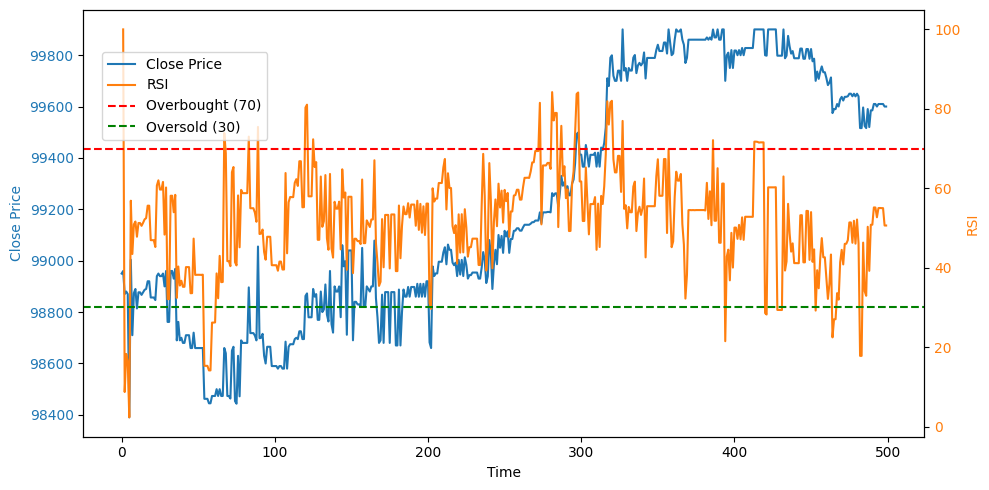

In [205]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(df['Close'], color=color, label='Close Price')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('RSI', color=color)
ax2.plot(df['RSI'], color=color, label='RSI')
ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
ax2.axhline(30, color='green', linestyle='--', label='Oversold (30)')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

In [224]:
import math 

def handle_kline(kline):
    try:
        if kline['x']:  # x가 true일 때 (종료된 경우)
            close_price = float(kline['c'])
            new_row = {
                "Open time": kline['t'],
                "Open": float(kline['o']),
                "High": float(kline['h']),
                "Low": float(kline['l']),
                "Close": close_price,
                "Volume": float(kline['v']),
                "Close time": kline['T'],
                "Quote asset volume": float(kline['q']),
                "Number of trades": int(kline['n']),
                "Taker buy base asset volume": float(kline['V']),
                "Taker buy quote asset volume": float(kline['Q']),
                "Ignore": kline['B']
            }
            df = df.append(new_row, ignore_index=True)
            df['RSI'] = calculate_rsi(df)
            print(df[['Close', 'RSI']].tail(10))
            
            # RSI가 30 이하일 때 매수 신호 생성
            if df['RSI'].iloc[-1] <= 30:
                print("Buy signal detected")

                entry_price = close_price * 0.995
                quantity = calculate_quantity(entry_price, LEVERAGE, 5)

                print('entryPrice={}, quantity={}'.format(entry_price, quantity))

                try:
                    print('ready to open orders')
                    UM_FUTURES_CLIENT_TEST.new_order(
                        symbol="BTCUSDT",
                        side="BUY",
                        type="LIMIT",
                        quantity=quantity,
                        timeInForce="GTC",
                        price=entry_price
                    )
                    UM_FUTURES_CLIENT_TEST.new_order(
                        symbol="BTCUSDT",
                        side="SELL",
                        type="STOP",
                        quantity=quantity,
                        price=entry_price * (0.95 + (0.05 * (1 - 1 / LEVERAGE))),
                        stopPrice=entry_price * (0.95 + (0.05 * (1 - 1 / LEVERAGE)))
                    )
                except Exception as e:
                    print("Order error: {}".format(e))
    except KeyError as e:
        print("Key error: Missing key {}".format(e))
    except ValueError as e:
        print("Value error: {}".format(e))
    except Exception as e:
        print("Unexpected error: {}".format(e))

def calculate_quantity(entry_price, leverage, size=100):
    try:
        res = UM_FUTURES_CLIENT_TEST.balance()
        df = pd.DataFrame(res)
        usdt_balance = df[df['asset'] == 'USDT']
        available = float(usdt_balance['availableBalance'].iloc[0])
        quantity = (available * (size / 100) / entry_price) * leverage

        return math.floor(quantity * 1000) / 1000
    except KeyError as e:
        print("Key error in balance data: Missing key {}".format(e))
    except IndexError as e:
        print("Index error: {}".format(e))
    except Exception as e:
        print("Unexpected error in calculate_quantity: {}".format(e))

In [5]:
from enum import Enum


class Test(Enum):
    A = "A"
    B = "B"

print([p.value for p in Test])

['A', 'B']


In [225]:
from binance.websocket.um_futures.websocket_client import UMFuturesWebsocketClient

def user_data_handler(_, message):
    print('user data below')
    print(message)

UM_FUTURES_CLIENT_WS_USER_DATA = UMFuturesWebsocketClient(on_message=user_data_handler)

res = UM_FUTURES_CLIENT_TEST.new_listen_key()
UM_FUTURES_CLIENT_WS_USER_DATA.user_data(listen_key=res['listenKey'])

user data below
{"result":null,"id":1736148116155}


In [226]:
import json

def message_handler(_, message):
    data = json.loads(message)
    print(data)

    if 'e' in data and data['e'] == 'kline':
        handle_kline(data['k'])

UM_FUTURES_CLIENT_WS = UMFuturesWebsocketClient(on_message=message_handler)

# Load kline stream data
UM_FUTURES_CLIENT_WS.kline(
    symbol="btcusdt",
    interval=INTERVAL,
)

{'result': None, 'id': 1736148117655}
{'e': 'kline', 'E': 1736148117808, 's': 'BTCUSDT', 'k': {'t': 1736148060000, 'T': 1736148119999, 's': 'BTCUSDT', 'i': '1m', 'f': 5804516638, 'L': 5804518833, 'o': '99203.00', 'c': '99195.80', 'h': '99238.20', 'l': '99184.00', 'v': '111.402', 'n': 2196, 'x': False, 'q': '11050990.78430', 'V': '68.096', 'Q': '6755296.08510', 'B': '0'}}
{'e': 'kline', 'E': 1736148118244, 's': 'BTCUSDT', 'k': {'t': 1736148060000, 'T': 1736148119999, 's': 'BTCUSDT', 'i': '1m', 'f': 5804516638, 'L': 5804518834, 'o': '99203.00', 'c': '99195.80', 'h': '99238.20', 'l': '99184.00', 'v': '111.654', 'n': 2197, 'x': False, 'q': '11075988.12590', 'V': '68.096', 'Q': '6755296.08510', 'B': '0'}}
{'e': 'kline', 'E': 1736148118637, 's': 'BTCUSDT', 'k': {'t': 1736148060000, 'T': 1736148119999, 's': 'BTCUSDT', 'i': '1m', 'f': 5804516638, 'L': 5804518872, 'o': '99203.00', 'c': '99191.50', 'h': '99238.20', 'l': '99184.00', 'v': '113.106', 'n': 2235, 'x': False, 'q': '11220019.93550', 'V

In [233]:
UM_FUTURES_CLIENT_WS_USER_DATA.stop()
UM_FUTURES_CLIENT_WS.stop()

Unexpected error: local variable 'df' referenced before assignment
       Close        RSI
574  99280.0  63.602968
575  99524.8  85.859414
576  99350.0  57.094546
577  99011.2  32.639521
578  99001.3  32.174866
579  99142.4  45.041400
580  99068.6  40.414545
581  99014.0  37.156253
582  98968.3  34.472190
583  98833.1  27.653269
Unexpected error: local variable 'df' referenced before assignment
Unexpected error: local variable 'df' referenced before assignment
Unexpected error: local variable 'df' referenced before assignment
       Close        RSI
575  99524.8  85.859414
576  99350.0  57.094546
577  99011.2  32.639521
578  99001.3  32.174866
579  99142.4  45.041400
580  99068.6  40.414545
581  99014.0  37.156253
582  98968.3  34.472190
583  98833.1  27.653269
584  98962.3  40.607512


In [227]:
type(pd.DataFrame())

pandas.core.frame.DataFrame

{'e': 'kline', 'E': 1736150101336, 's': 'BTCUSDT', 'k': {'t': 1736150100000, 'T': 1736150159999, 's': 'BTCUSDT', 'i': '1m', 'f': 5804557809, 'L': 5804557819, 'o': '99337.40', 'c': '99337.40', 'h': '99337.40', 'l': '99337.40', 'v': '0.504', 'n': 11, 'x': False, 'q': '50066.04960', 'V': '0', 'Q': '0', 'B': '0'}}
{'e': 'kline', 'E': 1736150102242, 's': 'BTCUSDT', 'k': {'t': 1736150100000, 'T': 1736150159999, 's': 'BTCUSDT', 'i': '1m', 'f': 5804557809, 'L': 5804557821, 'o': '99337.40', 'c': '99337.40', 'h': '99337.40', 'l': '99337.40', 'v': '0.559', 'n': 13, 'x': False, 'q': '55529.60660', 'V': '0', 'Q': '0', 'B': '0'}}
{'e': 'kline', 'E': 1736150102636, 's': 'BTCUSDT', 'k': {'t': 1736150100000, 'T': 1736150159999, 's': 'BTCUSDT', 'i': '1m', 'f': 5804557809, 'L': 5804557826, 'o': '99337.40', 'c': '99337.50', 'h': '99337.50', 'l': '99337.40', 'v': '0.628', 'n': 18, 'x': False, 'q': '62383.88940', 'V': '0.022', 'Q': '2185.42500', 'B': '0'}}
{'e': 'kline', 'E': 1736150102901, 's': 'BTCUSDT', 

In [234]:
UM_FUTURES_CLIENT_TEST.get_orders(symbol='BTCUSDT')

[]

       Close        RSI
576  99350.0  57.094546
577  99011.2  32.639521
578  99001.3  32.174866
579  99142.4  45.041400
580  99068.6  40.414545
581  99014.0  37.156253
582  98968.3  34.472190
583  98833.1  27.653269
584  98962.3  40.607512
585  98721.0  29.301194Unexpected error: local variable 'df' referenced before assignment
Unexpected error: local variable 'df' referenced before assignment

Unexpected error: local variable 'df' referenced before assignment
Unexpected error: local variable 'df' referenced before assignment
       Close        RSI
577  99011.2  32.639521
578  99001.3  32.174866
579  99142.4  45.041400
580  99068.6  40.414545
581  99014.0  37.156253
582  98968.3  34.472190
583  98833.1  27.653269
584  98962.3  40.607512
585  98721.0  29.301194
586  98741.5  31.179546


In [3]:
#!/usr/bin/env python

import time
import logging
from binance.lib.utils import config_logging
from binance.um_futures import UMFutures
from binance.websocket.um_futures.websocket_client import UMFuturesWebsocketClient

config_logging(logging, logging.DEBUG)


def message_handler(_, message):
    print(message)


client = UMFutures(KEY_TEST['client'], base_url=BASE_URL['testnet'])
client.exchange_info()

DEBUG:root:url: https://testnet.binancefuture.com/fapi/v1/exchangeInfo
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): testnet.binancefuture.com:443
DEBUG:urllib3.connectionpool:https://testnet.binancefuture.com:443 "GET /fapi/v1/exchangeInfo HTTP/1.1" 200 None
DEBUG:root:raw response from server:{"timezone":"UTC","serverTime":1736413129786,"futuresType":"U_MARGINED","rateLimits":[{"rateLimitType":"REQUEST_WEIGHT","interval":"MINUTE","intervalNum":1,"limit":6000},{"rateLimitType":"ORDERS","interval":"MINUTE","intervalNum":1,"limit":1200},{"rateLimitType":"ORDERS","interval":"SECOND","intervalNum":10,"limit":300}],"exchangeFilters":[],"assets":[{"asset":"USDT","marginAvailable":true,"autoAssetExchange":"-100"},{"asset":"BTC","marginAvailable":true,"autoAssetExchange":"-0.00100000"},{"asset":"BNB","marginAvailable":true,"autoAssetExchange":"-0.00100000"},{"asset":"ETH","marginAvailable":true,"autoAssetExchange":"-0.00100000"},{"asset":"USDC","marginAvailable":true,"autoAs

{'timezone': 'UTC',
 'serverTime': 1736413129786,
 'futuresType': 'U_MARGINED',
 'rateLimits': [{'rateLimitType': 'REQUEST_WEIGHT',
   'interval': 'MINUTE',
   'intervalNum': 1,
   'limit': 6000},
  {'rateLimitType': 'ORDERS',
   'interval': 'MINUTE',
   'intervalNum': 1,
   'limit': 1200},
  {'rateLimitType': 'ORDERS',
   'interval': 'SECOND',
   'intervalNum': 10,
   'limit': 300}],
 'exchangeFilters': [],
 'assets': [{'asset': 'USDT',
   'marginAvailable': True,
   'autoAssetExchange': '-100'},
  {'asset': 'BTC',
   'marginAvailable': True,
   'autoAssetExchange': '-0.00100000'},
  {'asset': 'BNB',
   'marginAvailable': True,
   'autoAssetExchange': '-0.00100000'},
  {'asset': 'ETH',
   'marginAvailable': True,
   'autoAssetExchange': '-0.00100000'},
  {'asset': 'USDC',
   'marginAvailable': True,
   'autoAssetExchange': '-0.10000000'},
  {'asset': 'FDUSD', 'marginAvailable': True, 'autoAssetExchange': '0'},
  {'asset': 'BNFCR', 'marginAvailable': True, 'autoAssetExchange': '-5000'}

In [12]:
#!/usr/bin/env python

import time
import logging
from binance.lib.utils import config_logging
from binance.um_futures import UMFutures
from binance.websocket.um_futures.websocket_client import UMFuturesWebsocketClient

config_logging(logging, logging.DEBUG)


def message_handler(_, message):
    print(message)


client = UMFutures(key=KEY_TEST['client'], secret=KEY_TEST['secret'], base_url=BASE_URL['testnet'])
client.new_order_test(
    symbol="BTCUSDT",
    type="TRAILING_STOP_MARKET",
    side="BUY",
    callbackRate=1,
    quantity=0.001,
    timeInForce="GTC",
)

DEBUG:root:url: https://testnet.binancefuture.com/fapi/v1/order/test
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): testnet.binancefuture.com:443
DEBUG:urllib3.connectionpool:https://testnet.binancefuture.com:443 "POST /fapi/v1/order/test?symbol=BTCUSDT&side=BUY&type=TRAILING_STOP_MARKET&callbackRate=1&quantity=0.001&timeInForce=GTC&timestamp=1736932440045&signature=5e533845787ea07c0dfc9c178b7379bee017ff466426262fd44f9fd4b61da3dd HTTP/1.1" 400 100
DEBUG:root:raw response from server:{"code":-4164,"msg":"Order's notional must be no smaller than 100 (unless you choose reduce only)."}


ClientError: (400, -4164, "Order's notional must be no smaller than 100 (unless you choose reduce only).", {'Content-Type': 'application/json', 'Content-Length': '100', 'Connection': 'keep-alive', 'Date': 'Wed, 15 Jan 2025 09:14:00 GMT', 'Strict-Transport-Security': 'max-age=31536000; includeSubdomains', 'Server': 'Bengine', 'x-mbx-used-weight-1m': '-1', 'x-mbx-order-count-10s': '1', 'x-mbx-order-count-1m': '1', 'x-response-time': '0ms', 'X-Frame-Options': 'SAMEORIGIN', 'X-Xss-Protection': '1; mode=block', 'X-Content-Type-Options': 'nosniff', 'Referrer-Policy': 'origin-when-cross-origin', 'X-Cache': 'Error from cloudfront', 'Via': '1.1 d7b911451ac5880a1bff3e540ab26408.cloudfront.net (CloudFront)', 'X-Amz-Cf-Pop': 'ICN57-P1', 'X-Amz-Cf-Id': 'Gsrh5QxZihgO_qVvxjlSvRZVOV_B72GZnLj3KgCwSphaOB8BqYgxOw=='})

In [1]:
[1] + [2]

[1, 2]

In [ ]:
%pip install slack-sdk

In [ ]:
from slack_sdk import WebClient
from slack_sdk.errors import SlackApiError

# Replace 'your-slack-bot-token' with your actual Slack Bot Token.
client = WebClient(token='your-slack-bot-token')

try:
    # Replace '#your-channel' with the Slack channel (or user ID) you wish to send the message to.
    response = client.chat_postMessage(
        channel='#your-channel',
        text="Hello, Slack! This is a message sent from Python 3."
    )
    # Optionally, you can check the response to confirm the message was sent.
    if response["ok"]:
        print("Message sent successfully!")
except SlackApiError as e:
    # Print the error if something goes wrong.
    print(f"Error sending message: {e.response['error']}")